In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor,num_images = 25,size = (1,28,28)):
  image_tensor = (image_tensor +1)/2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[ : num_images], nrow = 5)
  plt.imshow(image_grid.permute(1,2,0).squeeze())
  plt.show()

In [ ]:
class generator(nn.Module):
  def __init__(self,z_dim = 10, im_chan = 1, hidden_dim = 64 ):
    super(generator,self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
      self.get_gen_block(z_dim , hidden_dim *4),
      self.get_gen_block(hidden_dim * 4,hidden_dim *2, kernel_size = 4, stride = 1),
      self.get_gen_block(hidden_dim * 2, hidden_dim),
      self.get_gen_block(hidden_dim, im_chan, kernel_size = 4, final_layer = True)
    )
  def get_gen_block(self,input_channels, output_channels , kernel_size = 3 , stride = 2 , final_layer =False ):
    if (final_layer ==False):
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels,output_channels,kernel_size = kernel_size,stride = stride),
          nn.BatchNorm2d(output_channels),
          nn.ReLU(inplace=True)
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels,output_channels,kernel_size = kernel_size,stride = stride),
          nn.Tanh()
      )
  def unsqueeze_noise(self,noise):
    return noise.view(len(noise),self.z_dim,1,1)
  def forward(self,noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

def get_noise(n_samples , z_dim,device = 'cpu'):
  return torch.randn(n_samples,z_dim , device= device)


In [ ]:
gen = generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.get_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.get_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.get_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [ ]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, im_chan=1, hidden_dim=16):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        self.get_disc_block(im_chan, hidden_dim),
        self.get_disc_block(hidden_dim, hidden_dim*2),
        self.get_disc_block(hidden_dim*2,1,final_layer = True)
    )
  def get_disc_block(self,input_channel,output_channel,kernel=4,stride=2,final_layer=False):
    if final_layer == False:
      return nn.Sequential(nn.Conv2d(input_channel,output_channel,kernel_size=kernel,stride=stride),
                           nn.BatchNorm2d(output_channel),
                           nn.LeakyReLU(0.2,inplace = True)
                           )
    else:
      return nn.Sequential(
          nn.Conv2d(input_channel, output_channel, kernel, stride)
      )
  def forward(self,image):
    disc_pred = self.disc(image)
    return disc_pred.view(len(disc_pred),-1)

In [ ]:
num_test = 100

gen = generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.get_disc_block(1, 5, kernel=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.get_disc_block(1, 10, kernel=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [ ]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


In [ ]:
criterion =nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size =128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cpu'

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),])

dataloader = DataLoader(MNIST('.',download = True, transform = transform),batch_size = batch_size,shuffle = True)

In [ ]:
gen = generator(z_dim)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr,betas = (beta_1,beta_2))
disc = Discriminator()
disc_opt = torch.optim.Adam(disc.parameters(),lr = lr,betas=(beta_1,beta_2))
def weights_init(m):
  if isinstance(m,nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

en = gen.apply(weights_init)
disc = disc.apply(weights_init)

  7%|▋         | 31/469 [00:14<03:02,  2.41it/s]

Step 500: Generator loss: 0.9288991655111312, discriminator loss: 0.5189823468029496


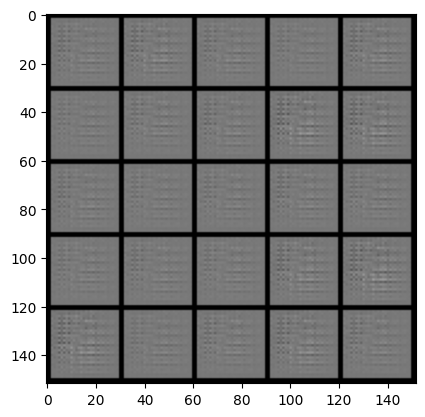

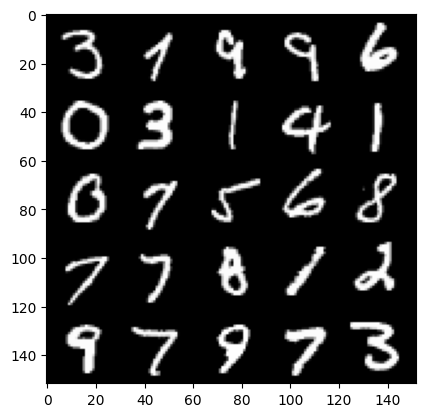

 13%|█▎        | 62/469 [00:30<04:55,  1.38it/s]

Step 1000: Generator loss: 2.1155001099407653, discriminator loss: 0.2051933193653821


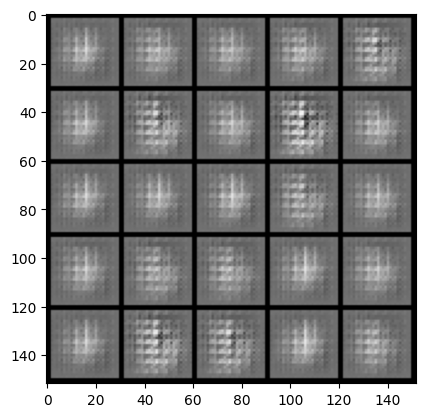

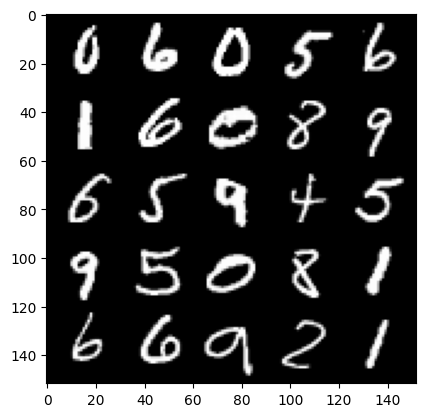

 20%|█▉        | 93/469 [00:45<02:38,  2.37it/s]

Step 1500: Generator loss: 1.7759607927799232, discriminator loss: 0.3470731241405005


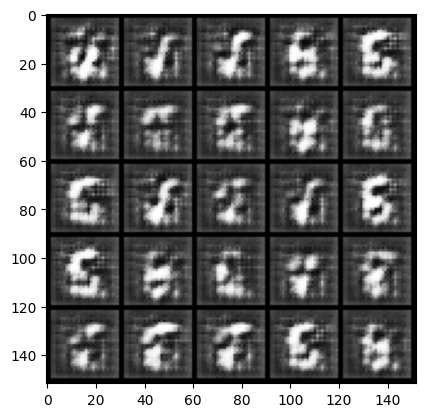

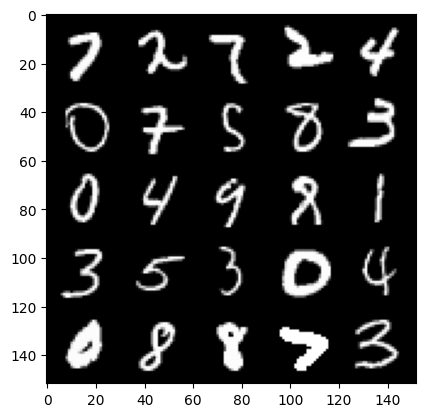

 26%|██▋       | 124/469 [01:01<02:24,  2.39it/s]

Step 2000: Generator loss: 1.287356874853373, discriminator loss: 0.48252910339832294


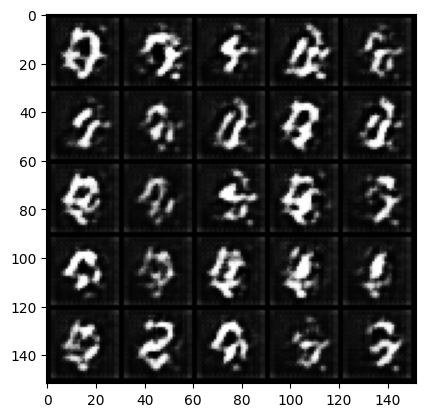

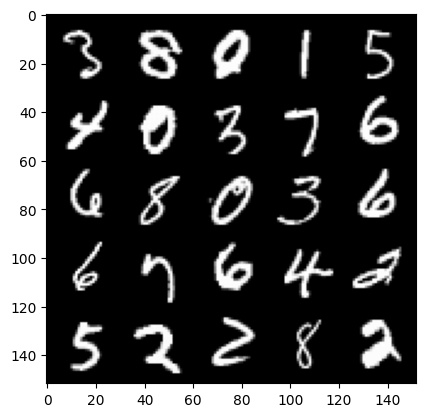

 33%|███▎      | 155/469 [01:14<03:01,  1.73it/s]

Step 2500: Generator loss: 1.0126870345473293, discriminator loss: 0.5656067280173299


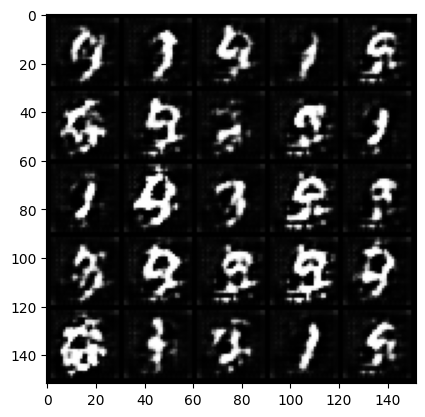

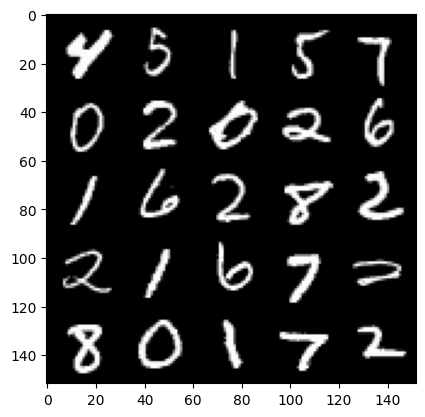

 40%|███▉      | 186/469 [01:29<01:58,  2.38it/s]

Step 3000: Generator loss: 0.919119588911534, discriminator loss: 0.5915164866447448


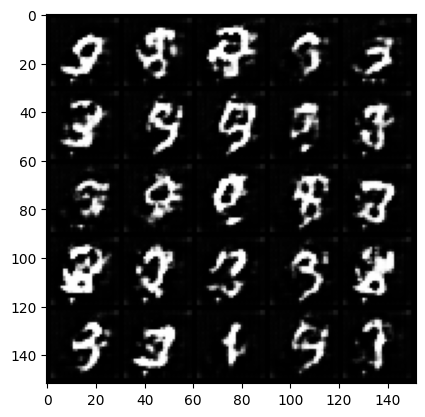

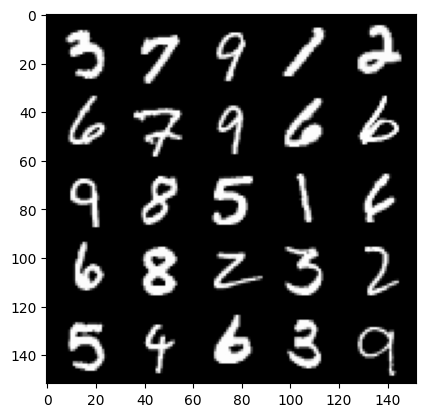

 46%|████▋     | 217/469 [01:46<01:49,  2.29it/s]

Step 3500: Generator loss: 0.8525794707536698, discriminator loss: 0.6183297256231308


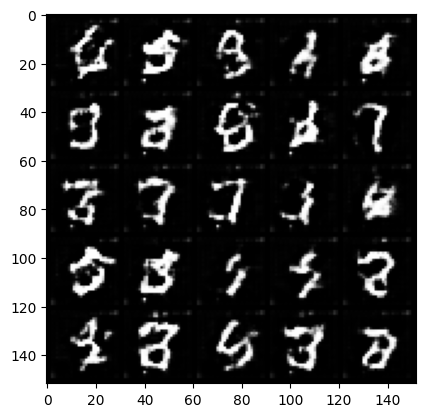

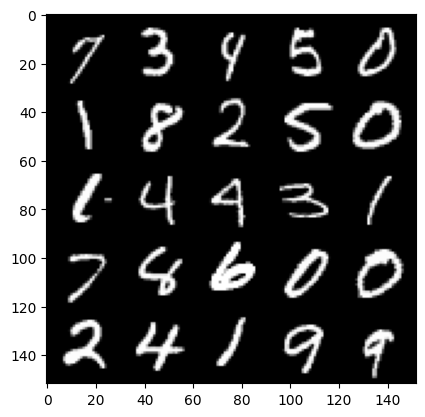

 53%|█████▎    | 248/469 [01:59<01:31,  2.42it/s]

Step 4000: Generator loss: 0.8023488270044329, discriminator loss: 0.6441954274177553


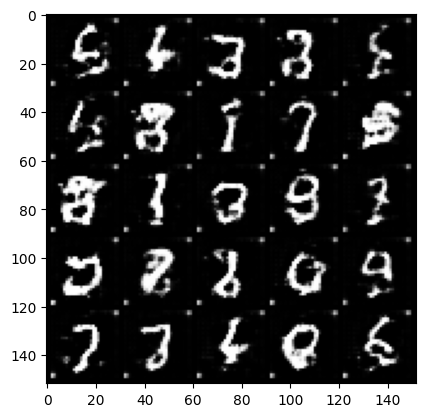

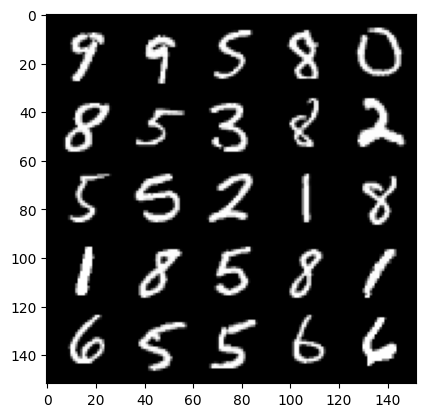

 59%|█████▉    | 279/469 [02:15<01:18,  2.41it/s]

Step 4500: Generator loss: 0.8061139119267468, discriminator loss: 0.6584266588687891


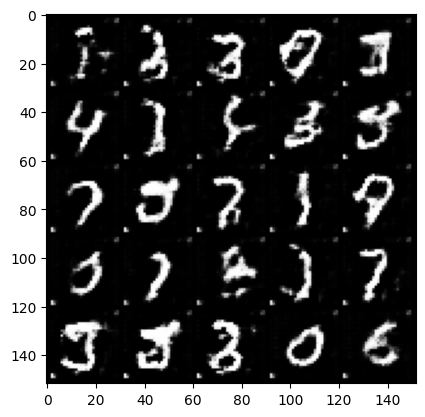

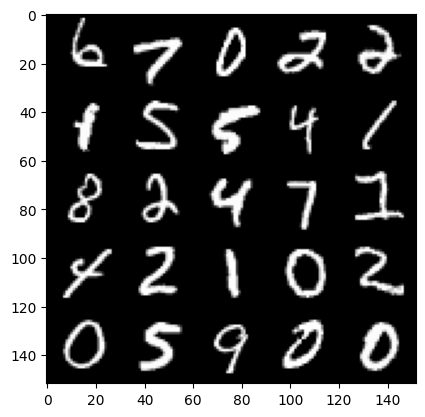

 66%|██████▌   | 310/469 [02:33<01:06,  2.40it/s]

Step 5000: Generator loss: 0.7686884458661076, discriminator loss: 0.6637076375484461


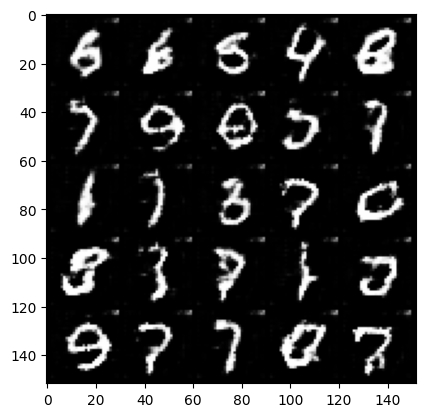

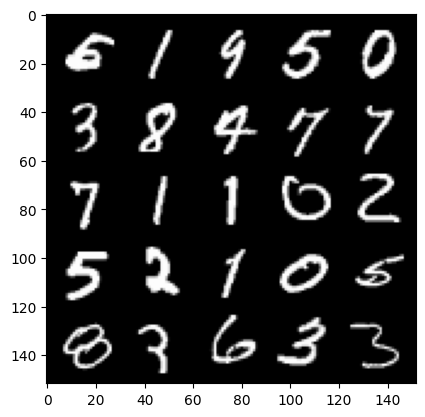

 73%|███████▎  | 341/469 [02:50<01:19,  1.61it/s]

Step 5500: Generator loss: 0.7662451463937756, discriminator loss: 0.6688405115604396


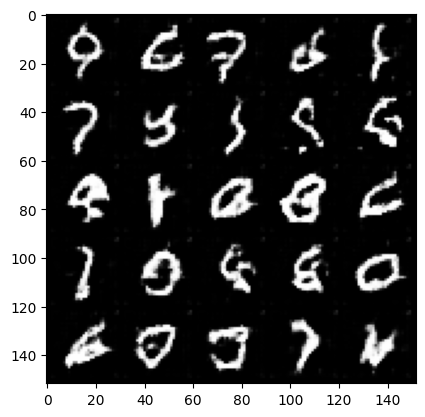

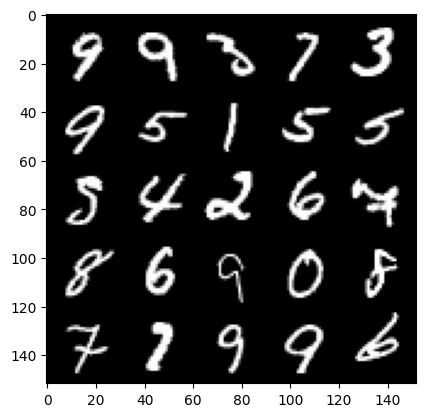

 79%|███████▉  | 372/469 [03:01<01:06,  1.45it/s]

Step 6000: Generator loss: 0.7652949559092526, discriminator loss: 0.6748836284875872


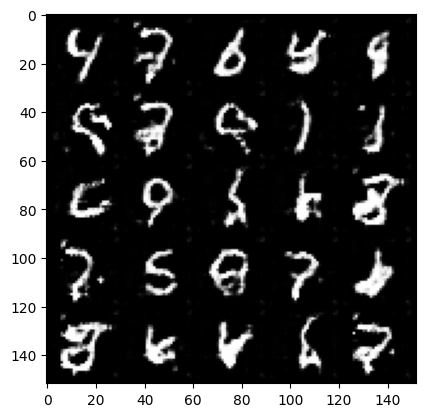

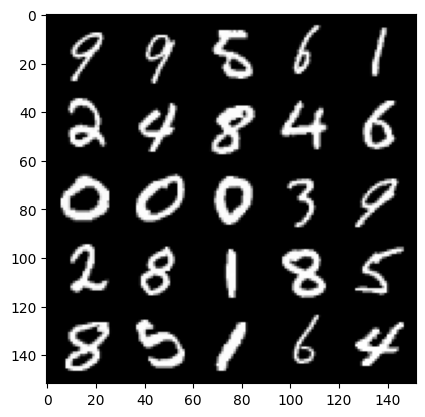

 86%|████████▌ | 403/469 [03:14<00:32,  2.05it/s]

Step 6500: Generator loss: 0.7641185743808749, discriminator loss: 0.674472418308258


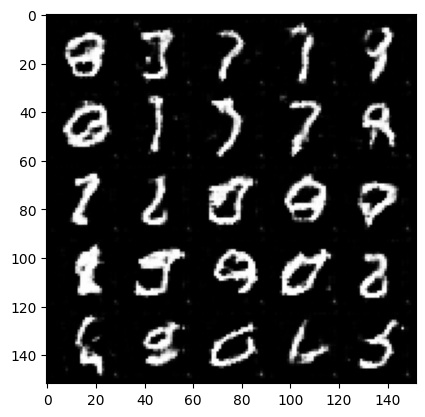

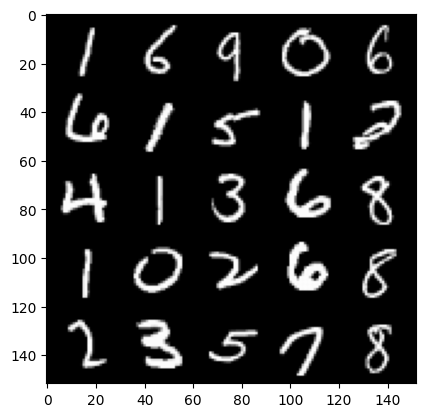

 93%|█████████▎| 434/469 [03:31<00:14,  2.36it/s]

Step 7000: Generator loss: 0.7540208926200869, discriminator loss: 0.6732462751865379


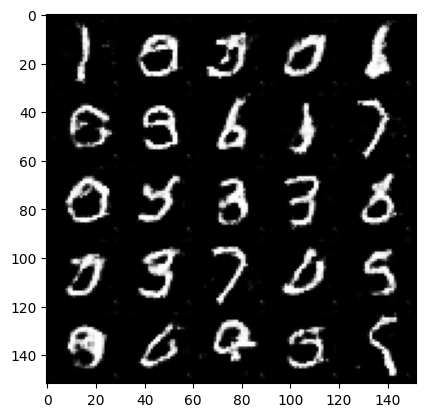

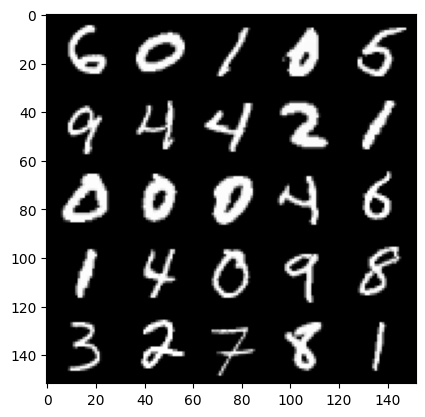

 99%|█████████▉| 465/469 [03:33<00:01,  2.03it/s]

Step 7500: Generator loss: 0.7561118692159654, discriminator loss: 0.6765329053401947


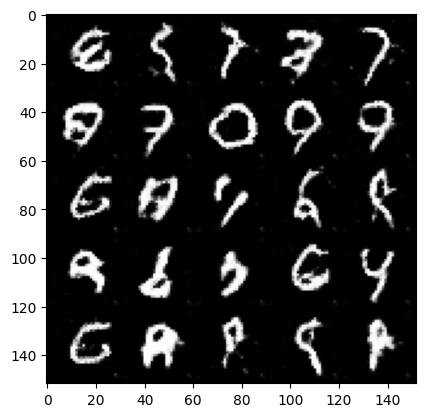

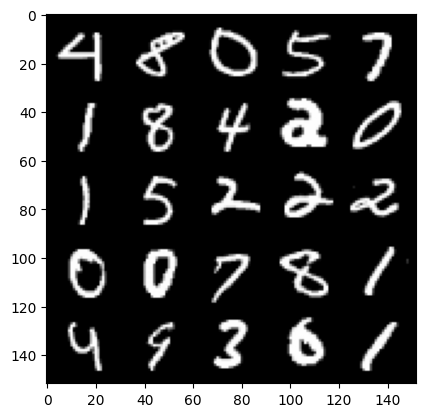

  6%|▌         | 27/469 [00:12<03:01,  2.44it/s]

Step 8000: Generator loss: 0.7485933287143701, discriminator loss: 0.679718311190605


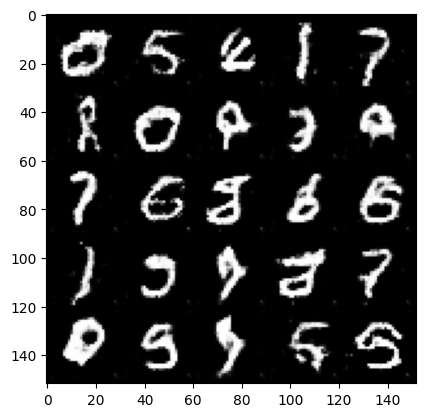

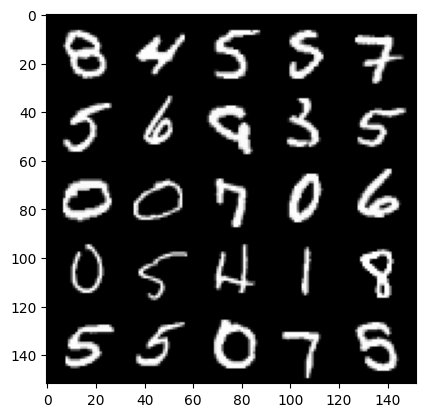

 12%|█▏        | 58/469 [00:26<03:02,  2.25it/s]

Step 8500: Generator loss: 0.7425748432874683, discriminator loss: 0.6822889652252198


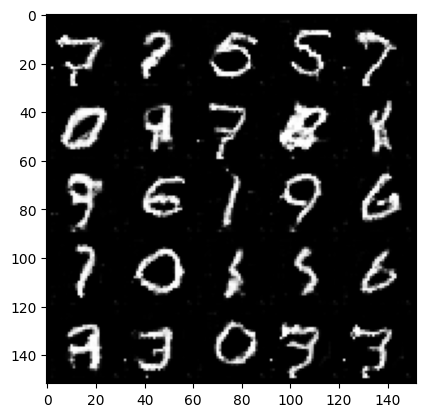

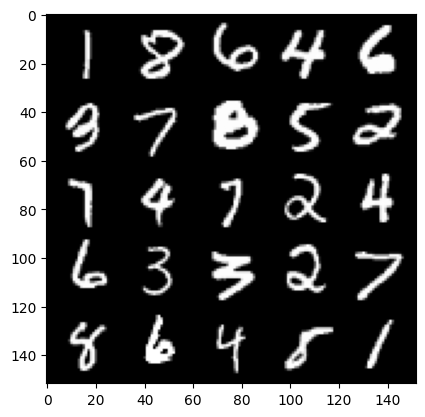

 19%|█▉        | 89/469 [00:40<03:01,  2.09it/s]

Step 9000: Generator loss: 0.7354754983186724, discriminator loss: 0.6857429076433184


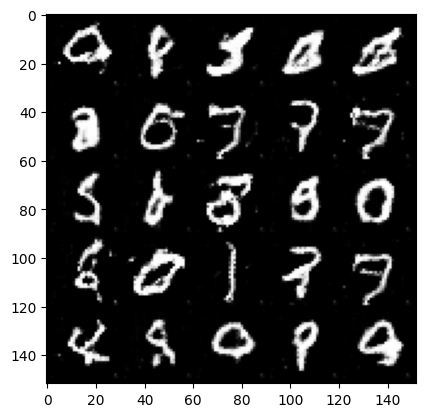

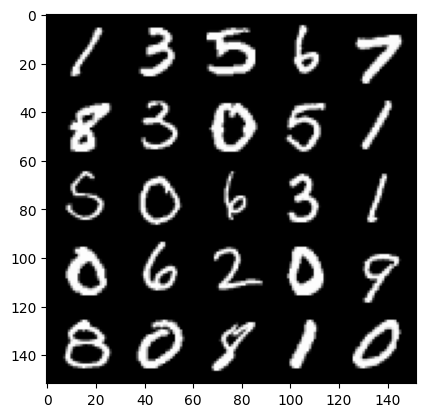

 26%|██▌       | 120/469 [00:54<02:35,  2.24it/s]

Step 9500: Generator loss: 0.733560482203961, discriminator loss: 0.6872368785142893


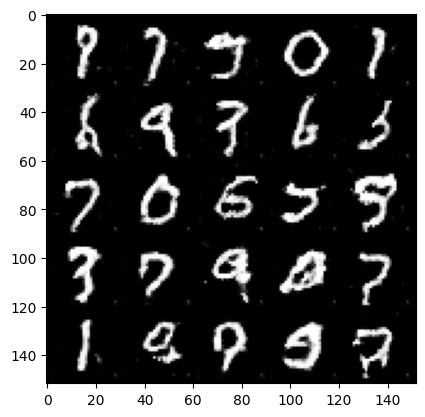

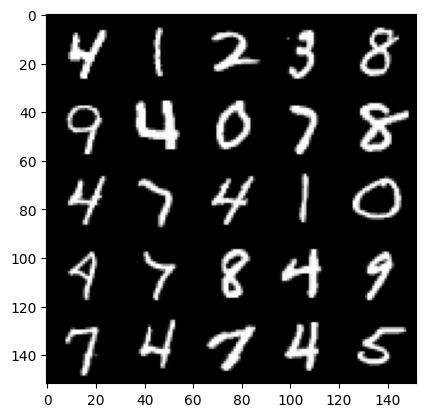

 32%|███▏      | 151/469 [01:08<02:24,  2.21it/s]

Step 10000: Generator loss: 0.7286798388957977, discriminator loss: 0.689451904535294


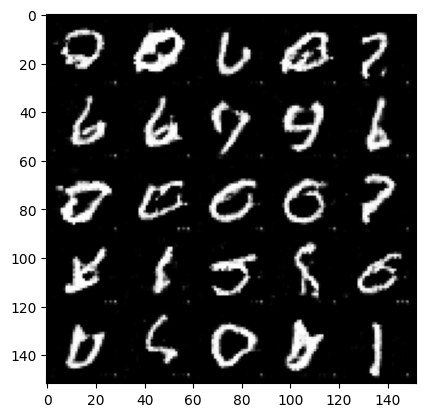

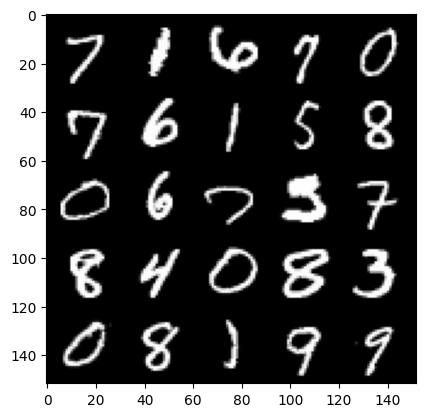

 39%|███▉      | 182/469 [01:23<02:20,  2.04it/s]

Step 10500: Generator loss: 0.7251690210103993, discriminator loss: 0.691824772357941


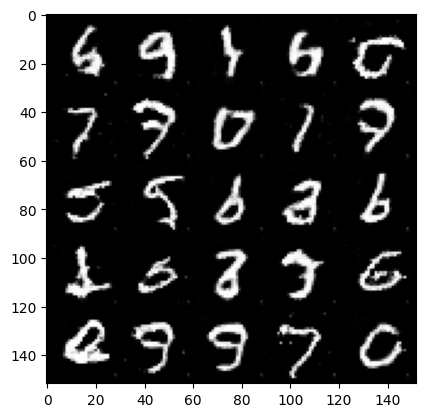

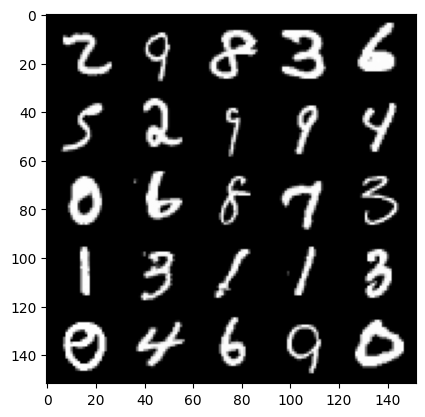

 45%|████▌     | 213/469 [01:38<02:12,  1.93it/s]

Step 11000: Generator loss: 0.7186967515945439, discriminator loss: 0.6936575175523758


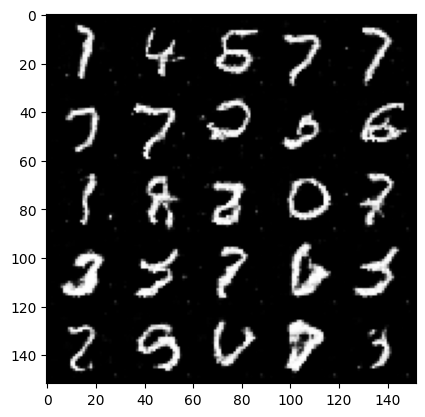

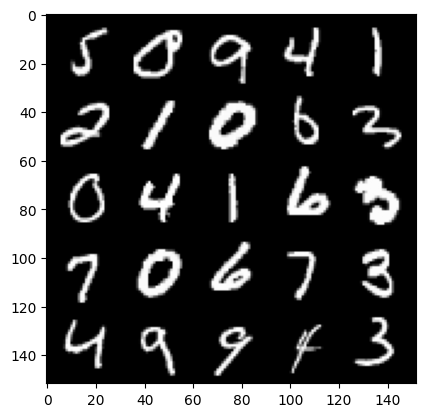

 52%|█████▏    | 244/469 [01:50<01:33,  2.39it/s]

Step 11500: Generator loss: 0.7147479434013367, discriminator loss: 0.6959399244785311


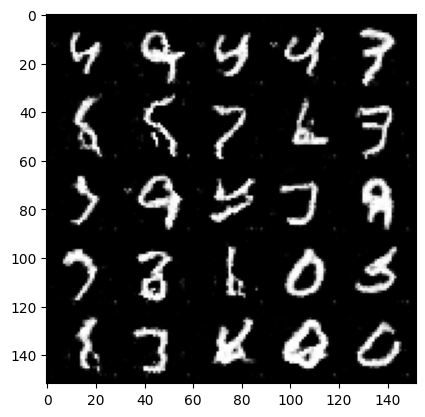

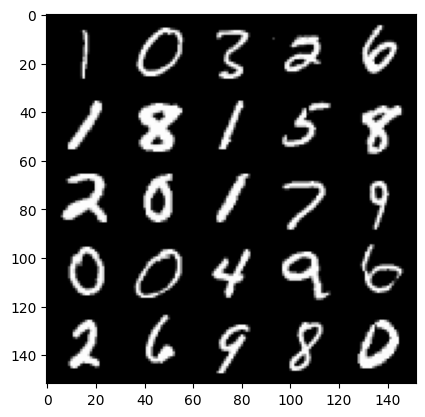

 59%|█████▊    | 275/469 [02:05<01:21,  2.38it/s]

Step 12000: Generator loss: 0.7158562570214274, discriminator loss: 0.69591622030735


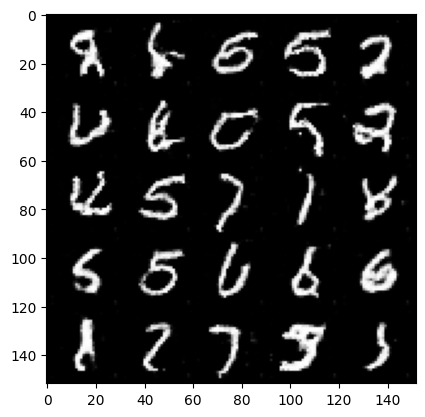

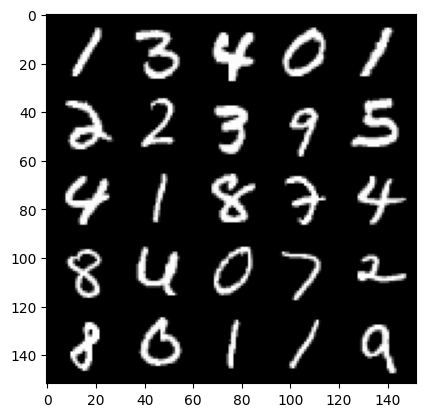

 65%|██████▌   | 306/469 [02:20<01:09,  2.35it/s]

Step 12500: Generator loss: 0.7106556163430213, discriminator loss: 0.6977862187623975


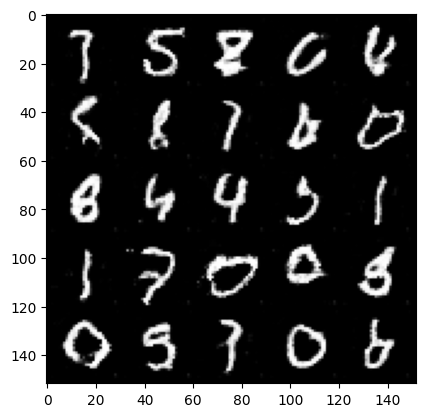

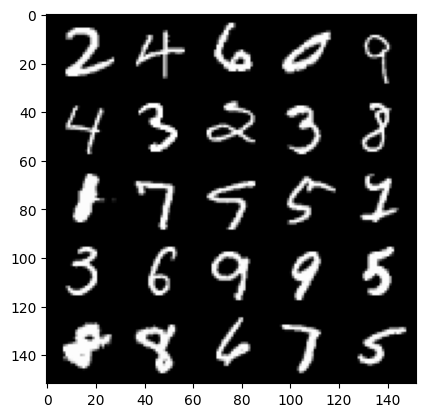

 72%|███████▏  | 337/469 [02:36<00:58,  2.28it/s]

Step 13000: Generator loss: 0.7140038855075842, discriminator loss: 0.69731520986557


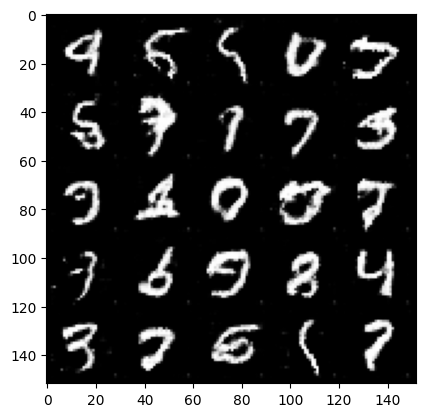

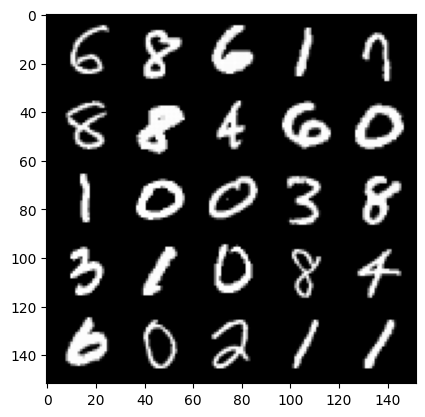

 78%|███████▊  | 368/469 [02:51<00:43,  2.31it/s]

Step 13500: Generator loss: 0.7093368468284604, discriminator loss: 0.6976346113681792


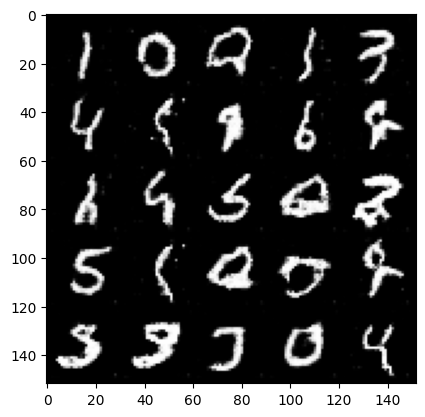

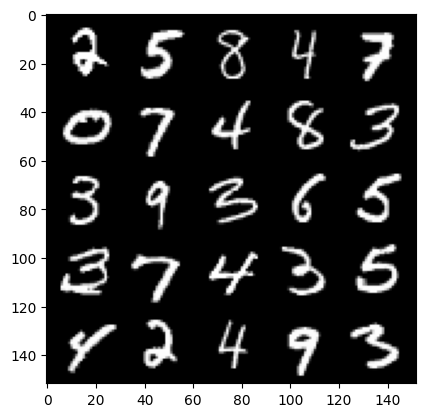

 85%|████████▌ | 399/469 [03:05<00:29,  2.34it/s]

Step 14000: Generator loss: 0.7065345045328141, discriminator loss: 0.6993050168752674


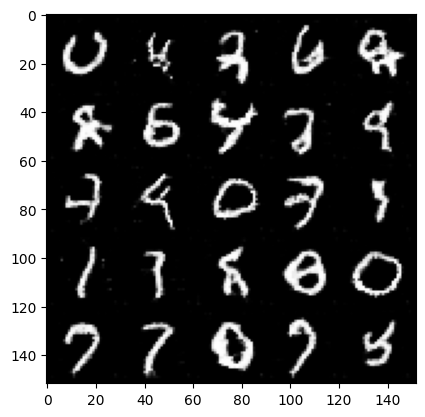

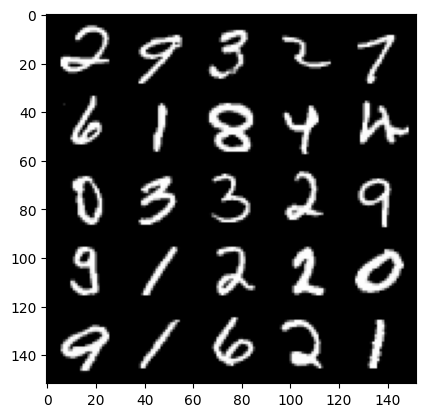

 92%|█████████▏| 430/469 [03:18<00:16,  2.33it/s]

Step 14500: Generator loss: 0.7071044472455971, discriminator loss: 0.6990298318862919


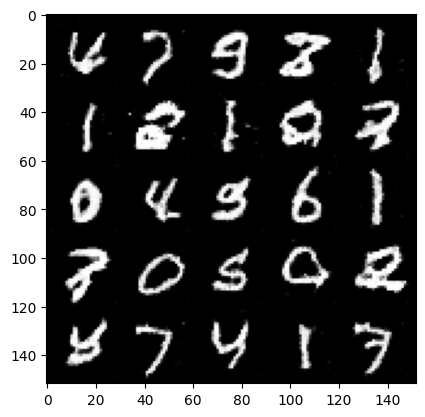

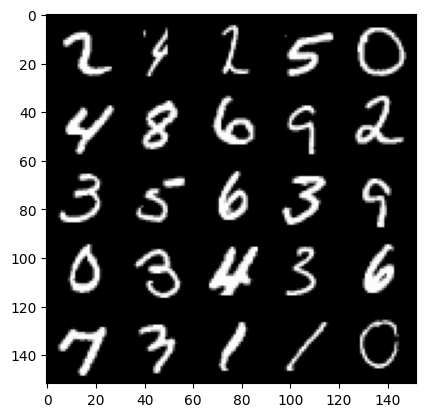

 98%|█████████▊| 461/469 [03:33<00:03,  2.33it/s]

Step 15000: Generator loss: 0.7045933763980867, discriminator loss: 0.6990270544290534


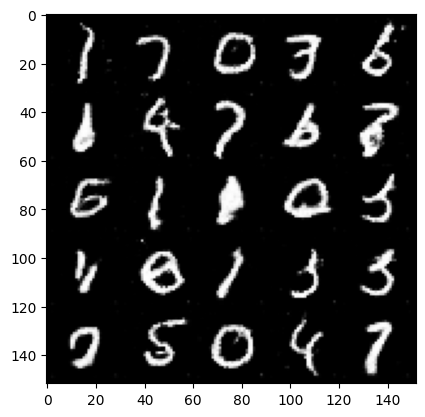

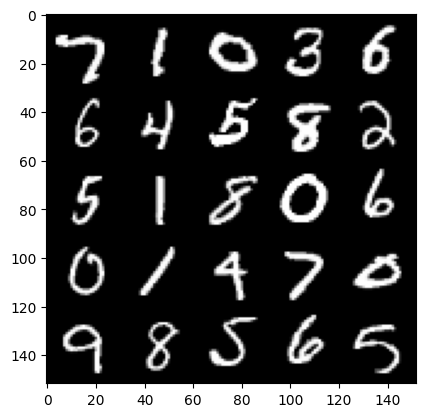

  5%|▍         | 23/469 [00:10<03:13,  2.31it/s]

Step 15500: Generator loss: 0.70262709736824, discriminator loss: 0.6985696595907213


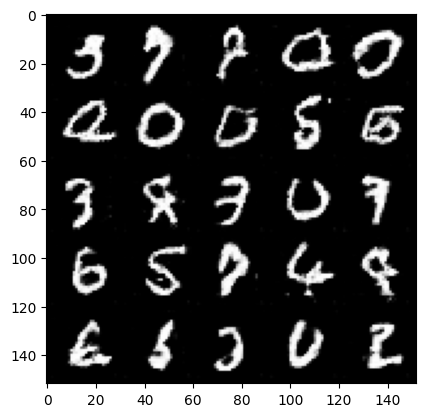

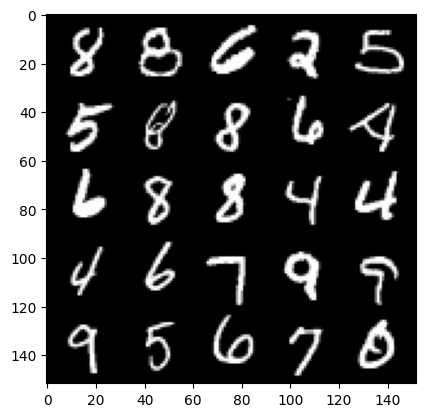

 12%|█▏        | 54/469 [00:25<02:59,  2.31it/s]

Step 16000: Generator loss: 0.7007010421156888, discriminator loss: 0.6991578185558325


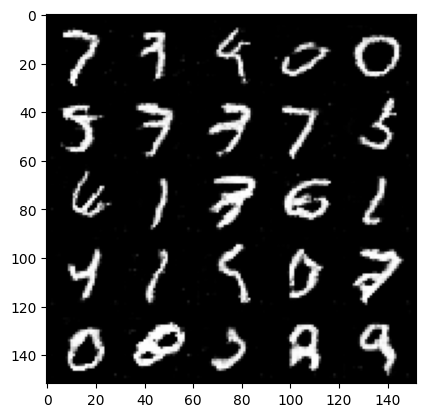

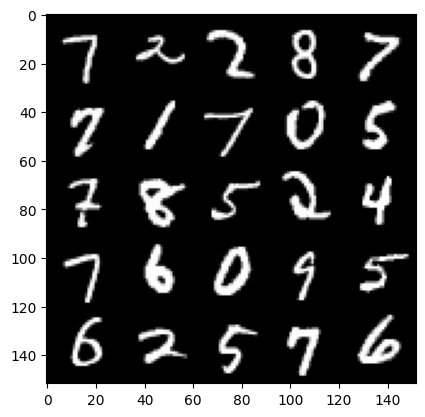

 18%|█▊        | 85/469 [00:39<02:45,  2.33it/s]

Step 16500: Generator loss: 0.7006224443912505, discriminator loss: 0.6987998305559162


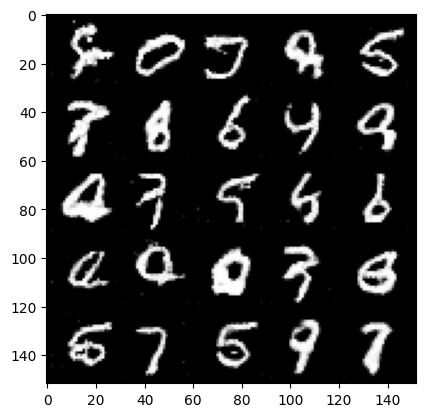

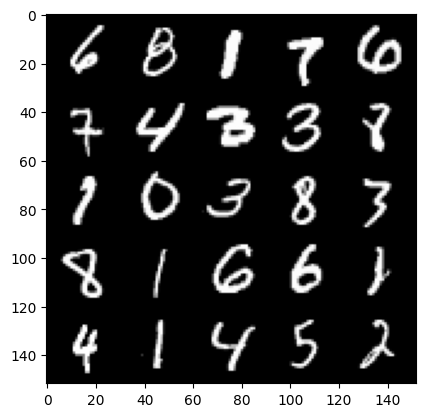

 25%|██▍       | 116/469 [00:53<02:30,  2.34it/s]

Step 17000: Generator loss: 0.7007951943278307, discriminator loss: 0.6991519222259525


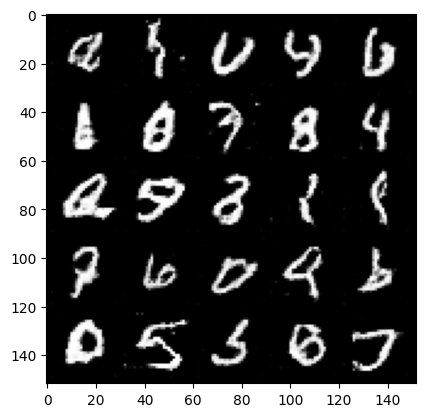

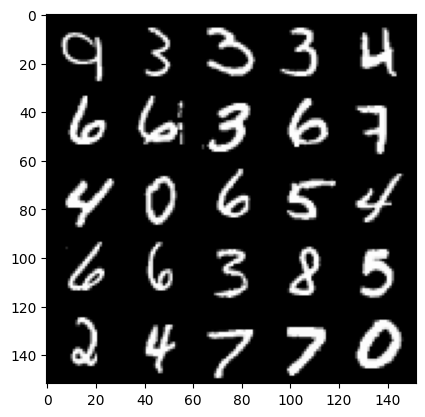

 31%|███▏      | 147/469 [01:09<02:42,  1.98it/s]

Step 17500: Generator loss: 0.6988441309928893, discriminator loss: 0.6981887054443358


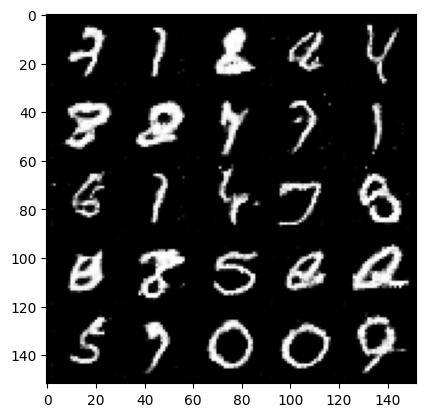

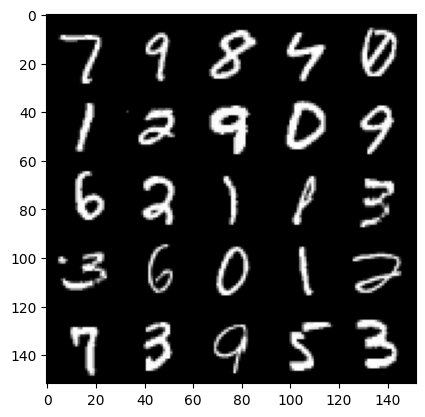

 38%|███▊      | 178/469 [01:23<02:53,  1.68it/s]

Step 18000: Generator loss: 0.7002248921394358, discriminator loss: 0.698598266124725


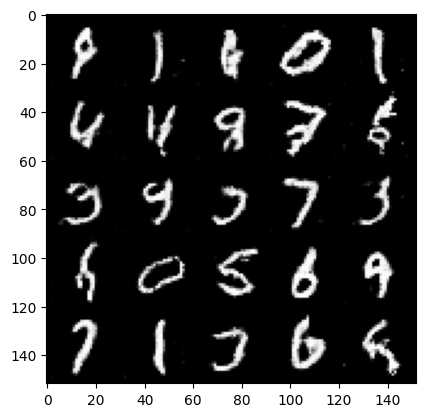

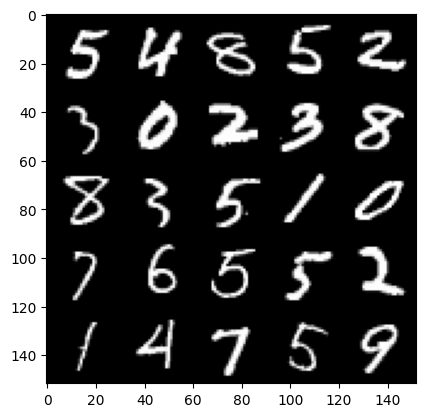

 45%|████▍     | 209/469 [01:38<02:02,  2.13it/s]

Step 18500: Generator loss: 0.6979128812551503, discriminator loss: 0.6978095487356185


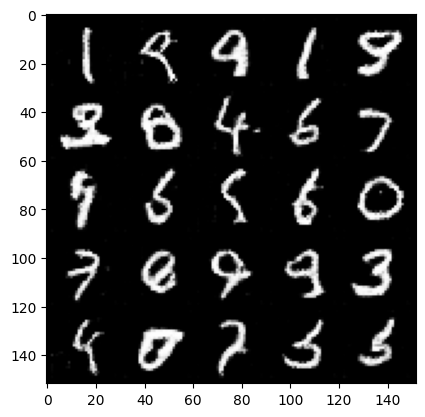

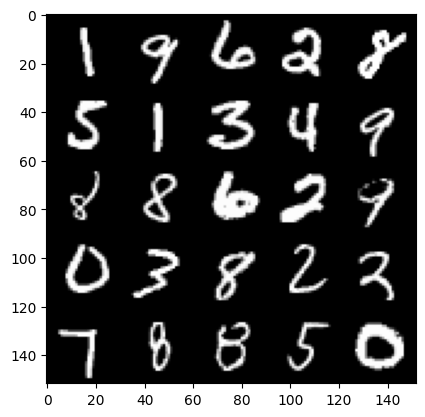

 51%|█████     | 240/469 [01:52<01:42,  2.24it/s]

Step 19000: Generator loss: 0.6989055184125899, discriminator loss: 0.6977131326198573


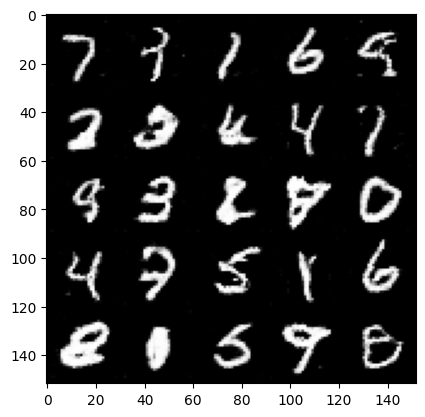

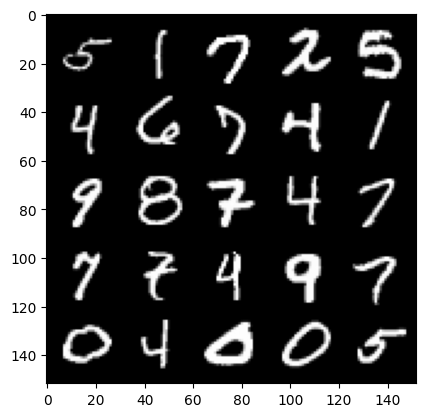

 58%|█████▊    | 271/469 [02:06<01:26,  2.29it/s]

Step 19500: Generator loss: 0.6981572699546811, discriminator loss: 0.6971160182952886


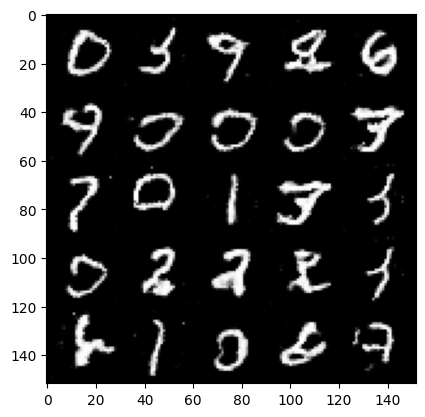

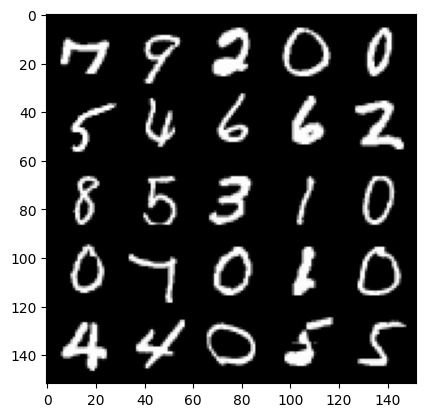

 64%|██████▍   | 302/469 [02:23<01:12,  2.31it/s]

Step 20000: Generator loss: 0.6979228955507268, discriminator loss: 0.6964190212488168


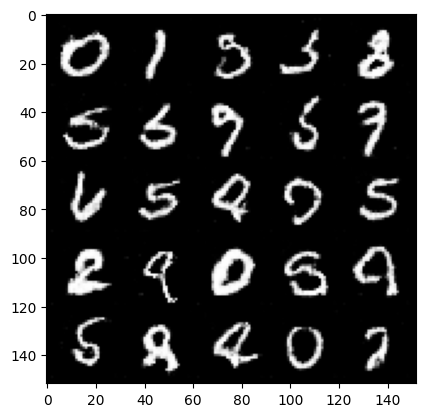

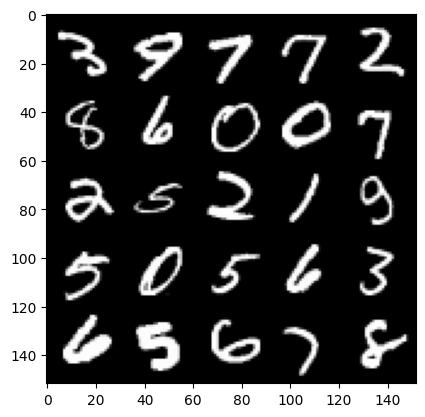

 71%|███████   | 333/469 [02:37<00:59,  2.28it/s]

Step 20500: Generator loss: 0.6996200056076046, discriminator loss: 0.6972137042284013


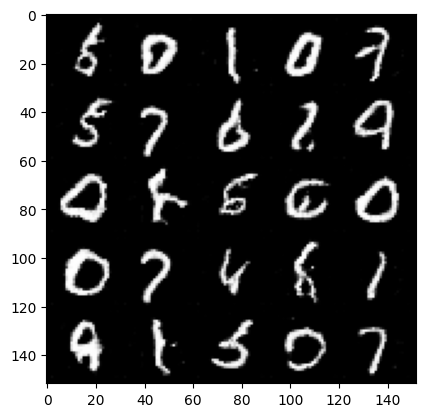

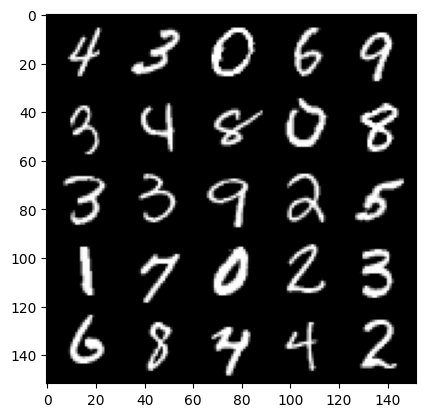

 78%|███████▊  | 364/469 [02:55<01:03,  1.66it/s]

Step 21000: Generator loss: 0.6988784500360486, discriminator loss: 0.6962627816200242


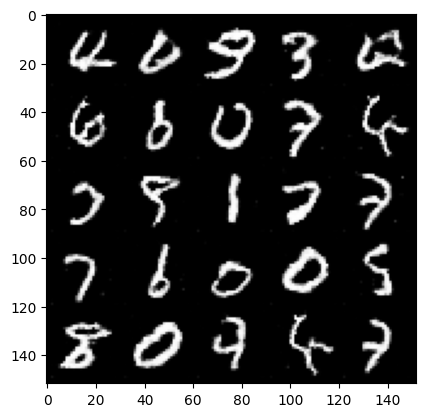

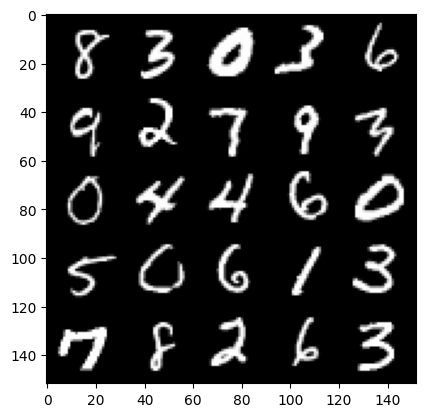

 84%|████████▍ | 395/469 [03:12<00:33,  2.21it/s]

Step 21500: Generator loss: 0.698163897633553, discriminator loss: 0.69603337931633


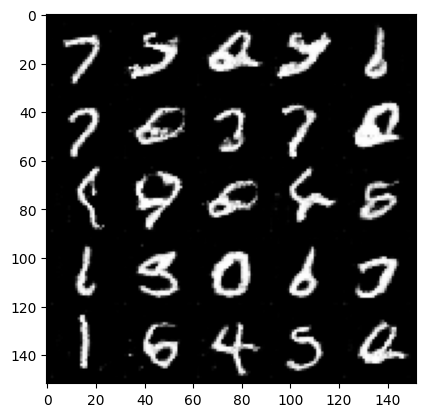

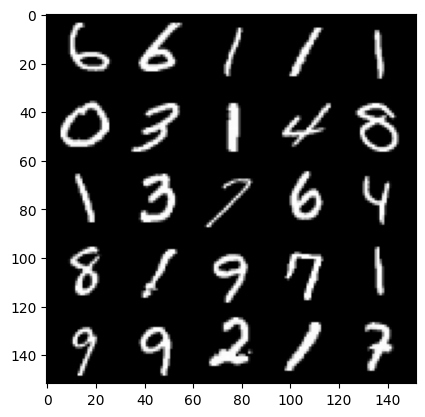

 91%|█████████ | 426/469 [03:28<00:22,  1.87it/s]

Step 22000: Generator loss: 0.698677295804024, discriminator loss: 0.6959684498310086


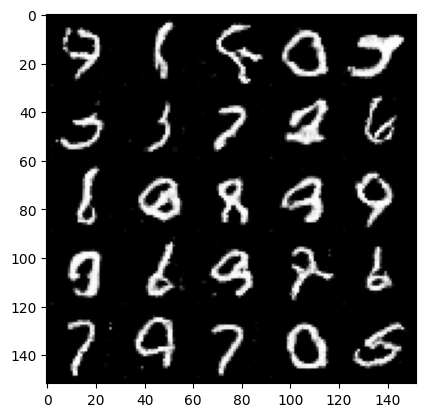

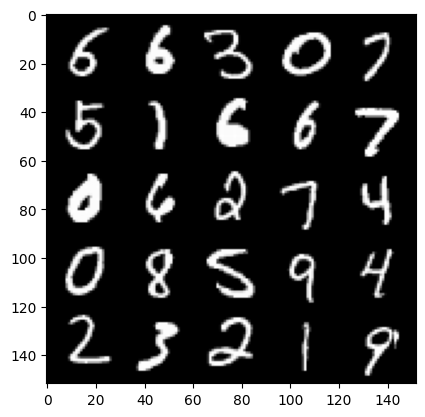

  8%|▊         | 36/469 [00:18<04:09,  1.73it/s]

In [ ]:
from tqdm import tqdm
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
  # Dataloader returns the batches
  for real, _ in tqdm(dataloader):
    cur_batch_size = len(real)

        ## Update discriminator ##
    disc_opt.zero_grad()
    fake_noise = get_noise(cur_batch_size, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
    mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
    disc_loss.backward(retain_graph=True)
        # Update optimizer
    disc_opt.step()

        ## Update generator ##
    gen_opt.zero_grad()
    fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
    fake_2 = gen(fake_noise_2)
    disc_fake_pred = disc(fake_2)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    gen_loss.backward()
    gen_opt.step()

        # Keep track of the average generator loss
    mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
    if cur_step % display_step == 0 and cur_step > 0:
      print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    cur_step += 1
